Начнём с загрузки основных необходимых библиотек. То, в чём будет возникать необходимость при дальныйшей обработке данных, будем подгружать по ходу выполнения

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pyspark
import pandas as pd

Создадим spark контекст и SQL контекст
Впомнив, что pyspark был запущен из командной строки (pyspark --master local[2]), предположим, что оба контекста уже были установлены, и нам необходимо их просто получить из кода.
Если не удаётся установить sql контекст, то необходимо проверить отсутствие блокировок (файлов вида *.lck в папке metastore_db, если таковые есть - завершаем выполнение pyspark, удаляем их и запускаем pyspark вновь).
Сразу же считаем данные для анализа из текстовых файлов в папке на уровень выше.
Данные, которые мы будем анализировать, содержатся в 3 частях - таблицах: ratings (рейтинг книг), books (информация о книгах), и users (информация о пользователях).

In [2]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext.getOrCreate(sc)
books = sc.textFile("..\BX-Books.csv")
users = sc.textFile("..\BX-Users.csv")
ratings = sc.textFile("..\BX-Book-Ratings.csv")

# Ratings

In [3]:
ratings.count()

1149780

In [4]:
ratings.take(5)

['"276725";"034545104X";"0"',
 '"276726";"0155061224";"5"',
 '"276727";"0446520802";"0"',
 '"276729";"052165615X";"3"',
 '"276729";"0521795028";"6"']

Отсюда видно, что данные рейтинга книг хранятся в виде:  
        -Идентификатор пользователя    
        -Идентификатор книги        
        -Рейтинг

Но данные могут содержать пропущенные значения,  быть помещены в кавычки, кроме того, они разделены точкой с запятой, иными словами, они нуждаются в предварительной обработке

In [6]:
def prepare_ratings_data(x):
    row = x.split(";")
    row2 = [row[0].replace("'","").replace('"',""), row[1].replace("'","").replace('"',""), float(row[2].replace("'","").replace('"',""))]
    return row2

In [7]:
ratings_csv = ratings.map(prepare_ratings_data)

In [8]:
ratings_csv.take(5)

[['276725', '034545104X', 0.0],
 ['276726', '0155061224', 5.0],
 ['276727', '0446520802', 0.0],
 ['276729', '052165615X', 3.0],
 ['276729', '0521795028', 6.0]]

Таким образом, данные уже принимают более удобный для работы вид

Подгрузим библиотеки для перевода наших данных в вид dataframe для последующей обработки средствами spark

In [12]:
from pyspark.sql import SQLContext, Row

Создадим таблицу с данными рейтинга книг от пользователей

In [13]:
ratings_info = sqlContext.createDataFrame(ratings_csv, ['userId', 'ISBN', 'bookRating'])

In [14]:
ratings_info.show()

+------+----------+----------+
|userID|      ISBN|bookRating|
+------+----------+----------+
|276725|034545104X|       0.0|
|276726|0155061224|       5.0|
|276727|0446520802|       0.0|
|276729|052165615X|       3.0|
|276729|0521795028|       6.0|
|276733|2080674722|       0.0|
|276736|3257224281|       8.0|
|276737|0600570967|       6.0|
|276744|038550120X|       7.0|
|276745| 342310538|      10.0|
|276746|0425115801|       0.0|
|276746|0449006522|       0.0|
|276746|0553561618|       0.0|
|276746|055356451X|       0.0|
|276746|0786013990|       0.0|
|276746|0786014512|       0.0|
|276747|0060517794|       9.0|
|276747|0451192001|       0.0|
|276747|0609801279|       0.0|
|276747|0671537458|       9.0|
+------+----------+----------+
only showing top 20 rows



Вроде бы с данными всё хорошо.
Зачем же было всё усложнять, почему не воспользоваться, например, ratings_info = ratings.toDF() или ratings_info = SqlContext.read.csv("..\BX-Book-Ratings.csv")? Вроде бы, намного проще, однако данные методы в моём случае отработали с ошибкой при обращении к metastore_db, поэтому ищем доступное решение

## Ratings Distribution

In [15]:
from pyspark.sql.functions import col

Попробуем оценить, какая оценка чаще всего выставлялась книгам.
Для этого сгруппируем данные по рейтингу книги и выведем количество голосов в порядке возрастания рейтинга. Как ни странно, наиболее популярная оценка - 0, за ней - 8

In [16]:
ratings_dist = ratings_info.groupBy('bookRating').count().sort(col("bookRating").asc())
ratings_dist.show()

+----------+------+
|bookRating| count|
+----------+------+
|       0.0|716109|
|       1.0|  1770|
|       2.0|  2759|
|       3.0|  5996|
|       4.0|  8904|
|       5.0| 50974|
|       6.0| 36924|
|       7.0| 76457|
|       8.0|103736|
|       9.0| 67541|
|      10.0| 78610|
+----------+------+



Чтобы представить данные в виде графика, переведем их в формат pandas

In [17]:
ratings_dist_pds = ratings_dist.toPandas()
ratings_dist_pds

,bookRating,count
0,0.0,716109
1,1.0,1770
2,2.0,2759
3,3.0,5996
4,4.0,8904
5,5.0,50974
6,6.0,36924
7,7.0,76457
8,8.0,103736
9,9.0,67541


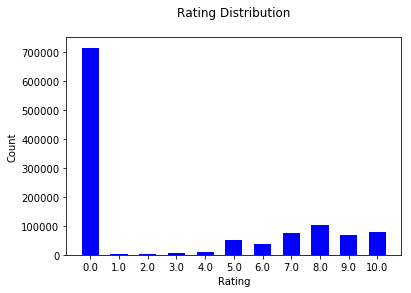

In [18]:
ind = np.array(ratings_dist_pds['bookRating'])
width = 1

p1 = plt.bar(ind, np.array(ratings_dist_pds['count']), 0.6, color='b')
plt.title('Rating Distribution\n')
plt.ylabel('Count')
plt.xlabel('Rating')
plt.xticks(ind, ind)


# Books

Аналогично данным рейтингов подготовим данные книг.
Определим функцию, подчищающую данные

In [91]:
def prepare_book_data(x):
    row = x.split(';')
    return [row[0].replace("'","").replace('"',""),row[1].replace("'","").replace('"',""),row[2].replace("'","").replace('"',""),
            row[3].replace("'","").replace('"',""),row[4].replace("'","").replace('"',""),row[5].replace("'","").replace('"',""),
            row[6].replace("'","").replace('"',""),row[7].replace("'","").replace('"',"")]

In [94]:
books_info = sqlContext.createDataFrame(books.map(lambda x:  prepare_books_data(x)),  ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL'])

In [95]:
books_info.show()

+----------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|           bookTitle|          bookAuthor|yearOfPublication|           publisher|           imageUrlS|           imageUrlM|           imageUrlL|
+----------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|             2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|             2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|         Carlo DEste|             1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari Kolata|    

# Users

In [97]:
def prepare_users_data(x):
    row = x.split(";")
    if (len(row)<2):
        return ( [row[0].replace("'","").replace('"',""), "", np.nan, np.nan] )
    if (len(row)<3):
        return ( [row[0].replace("'","").replace('"',""), row[1].replace("'","").replace('"',""), np.nan, np.nan] )
    age = row[2].replace("'","").replace('"',"")
    try:
        age_num = float(age)
        age_pos = (age_num//10+1)*10
    except Exception:
        age_num = np.nan
        age_pos = np.nan
    row2 = [row[0].replace("'","").replace('"',""), row[1].replace("'","").replace('"',""), age_num, age_pos] 
    return row2

In [98]:
users_info=sqlContext.createDataFrame(users.map(lambda x:  prepare_users_data(x)), ['userId', 'Location', 'Age', "Age-hist"])

In [99]:
users_info.show()

+------+--------------------+----+--------+
|userID|            Location| Age|Age-hist|
+------+--------------------+----+--------+
|     1|  nyc, new york, usa| NaN|     NaN|
|     2|stockton, califor...|18.0|    20.0|
|     3|moscow, yukon ter...| NaN|     NaN|
|     4|porto, v.n.gaia, ...|17.0|    20.0|
|     5|farnborough, hant...| NaN|     NaN|
|     6|santa monica, cal...|61.0|    70.0|
|     7| washington, dc, usa| NaN|     NaN|
|     8|timmins, ontario,...| NaN|     NaN|
|     9|germantown, tenne...| NaN|     NaN|
|    10|albacete, wiscons...|26.0|    30.0|
|    11|melbourne, victor...|14.0|    20.0|
|    12|fort bragg, calif...| NaN|     NaN|
|    13|barcelona, barcel...|26.0|    30.0|
|    14|mediapolis, iowa,...| NaN|     NaN|
|    15|calgary, alberta,...| NaN|     NaN|
|    16|albuquerque, new ...| NaN|     NaN|
|    17|chesapeake, virgi...| NaN|     NaN|
|    18|rio de janeiro, r...|25.0|    30.0|
|    19|           weston, ,|14.0|    20.0|
|    20|langhorne, pennsy...|19.

## Age distribution

Построим график распределения пользователей, выставлявших оценки книгам, по возрасту. Для этого подготовим выборку данных из таблицы пользователей (сгруппируем по столбцу верхней границы возраста - возраст относится к группам "до х лет" -, и выведем количество пользователей, относящихся к данной группе.

In [100]:
age_dist = users_info.groupBy('Age-hist').count().sort(col("Age-hist").asc())
age_dist.show()

+--------+-----+
|Age-hist|count|
+--------+-----+
|    10.0| 1068|
|    20.0|18845|
|    30.0|51484|
|    40.0|41878|
|    50.0|26698|
|    60.0|18810|
|    70.0| 6913|
|    80.0| 1644|
|    90.0|  199|
|   100.0|   62|
|   110.0|  276|
|   120.0|   19|
|   130.0|   15|
|   140.0|    7|
|   150.0|   13|
|   160.0|    6|
|   170.0|    2|
|   180.0|    2|
|   190.0|    3|
|   200.0|    2|
+--------+-----+
only showing top 20 rows



Переведем данные распределения по возрастным группам в pandas. Заметим, что для значительного количества пользователей возраст не указан. Ну а кто-то явно накинул себе лишнюю сотню-другую)

In [101]:
age_dist_pds = age_dist.toPandas()
age_dist_pds

,Age-hist,count
0,10.0,1068
1,20.0,18845
2,30.0,51484
3,40.0,41878
4,50.0,26698
5,60.0,18810
6,70.0,6913
7,80.0,1644
8,90.0,199
9,100.0,62


За неимением возможности объективно оценить возраст пользователей, которые его явно не указали, удалим пустые значения из нашей выборки.

In [102]:
age_dist_pds = age_dist_pds.dropna()
age_dist_pds

,Age-hist,count
0,10.0,1068
1,20.0,18845
2,30.0,51484
3,40.0,41878
4,50.0,26698
5,60.0,18810
6,70.0,6913
7,80.0,1644
8,90.0,199
9,100.0,62


Построим график распределения полльзователей по возрастным группам

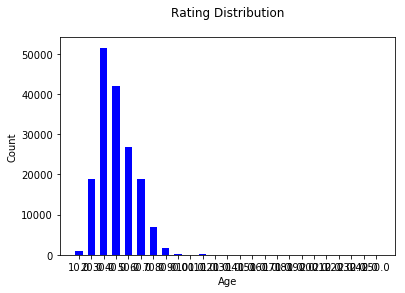

In [103]:
ind = np.array(range(0, len(age_dist_pds['Age-hist'])))

p1 = plt.bar(ind, age_dist_pds['count'], 0.6, color='b')
plt.title('Rating Distribution\n')
plt.ylabel('Count')
plt.xlabel('Age')
plt.xticks(ind, age_dist_pds['Age-hist'])

# Recommendations based on rating counts

Сгруппируем данные книг по идентификаторам книг и подсчитаем количество голосов, полученных каждой книгой

In [104]:
av = ratings_info.groupBy('ISBN').agg(
    pyspark.sql.functions.count('bookRating').alias("rcnt")
  ).sort(col("rcnt").desc())
av.show()

+----------+------------+
|      ISBN|ratingsCount|
+----------+------------+
|0971880107|        2502|
|0316666343|        1295|
|0385504209|         883|
|0060928336|         732|
|0312195516|         723|
|044023722X|         647|
|0679781587|         639|
|0142001740|         615|
|067976402X|         614|
|0671027360|         586|
|0446672211|         585|
|059035342X|         571|
|0316601950|         568|
|0375727345|         552|
|044021145X|         529|
|0452282152|         526|
|0440214041|         523|
|0804106304|         519|
|0440211727|         517|
|0345337662|         506|
+----------+------------+
only showing top 20 rows



Книгу с идентификатором "0971880107" оценило наибольшее число пользователей, у неё наивысший рейтинг. Выведем топ-5 книг по рейтингу в отдельную таблицу.

In [105]:
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
#most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
#most_rated_books_summary
most_rated_books = sqlContext.createDataFrame([('0971880107',), ('0316666343',), ('0385504209',), 
                                           ('0060928336',), ('0312195516',)], ["ISBN"])
most_rated_books.show()


+----------+
|      ISBN|
+----------+
|0971880107|
|0316666343|
|0385504209|
|0060928336|
|0312195516|
+----------+



Соединим идентификаторы книг с информацией о них

In [106]:
mrb_info = most_rated_books.alias("mrb").join(books_info.alias('book'), col("mrb.ISBN") == col("book.ISBN"))

In [108]:
mrb_info.show()

+----------+----------+--------------------+-------------+-----------------+-------------+--------------------+--------------------+--------------------+
|      ISBN|      ISBN|           bookTitle|   bookAuthor|yearOfPublication|    publisher|           imageUrlS|           imageUrlM|           imageUrlL|
+----------+----------+--------------------+-------------+-----------------+-------------+--------------------+--------------------+--------------------+
|0385504209|0385504209|   The Da Vinci Code|    Dan Brown|             2003|    Doubleday|http://images.ama...|http://images.ama...|http://images.ama...|
|0312195516|0312195516|The Red Tent (Bes...|Anita Diamant|             1998|  Picador USA|http://images.ama...|http://images.ama...|http://images.ama...|
|0316666343|0316666343|The Lovely Bones:...| Alice Sebold|             2002|Little, Brown|http://images.ama...|http://images.ama...|http://images.ama...|
|0060928336|0060928336|Divine Secrets of...|Rebecca Wells|             1997|

Для демонстрации результатов в более удобоваримом виде переведем таблицу расширенной информации по наиболее популярным книгам в pandas

In [109]:
mrb_info_pds = mrb_info.toPandas()
mrb_info_pds

,ISBN,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0385504209,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
1,0312195516,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
2,0316666343,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
3,0060928336,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0971880107,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...


# Recommendations based on correlations
Подсчитаем среднее значение оценки (рейтинга) каждой книги и количество отданных за нее голосов

In [110]:
av = ratings_info.groupBy('ISBN').agg(
    pyspark.sql.functions.mean('bookRating').alias("Mean"),
    pyspark.sql.functions.count('bookRating').alias("ratingsCount")
  ).sort(col("ratingsCount").desc())

In [44]:
av.show()

+----------+------------------+------------+
|      ISBN|              Mean|ratingsCount|
+----------+------------------+------------+
|0971880107|1.0195843325339728|        2502|
|0316666343| 4.468725868725869|        1295|
|0385504209| 4.652321630804077|         883|
|0060928336| 3.448087431693989|         732|
|0312195516| 4.334716459197787|         723|
|044023722X| 3.187017001545595|         647|
|0679781587| 4.381846635367762|         639|
|0142001740| 4.219512195121951|         615|
|067976402X| 3.255700325732899|         614|
|0671027360| 3.718430034129693|         586|
|0446672211| 4.105982905982906|         585|
|059035342X| 4.900175131348512|         571|
|0316601950|3.5933098591549295|         568|
|0375727345| 3.039855072463768|         552|
|044021145X|3.0756143667296785|         529|
|0452282152| 4.218631178707224|         526|
|0440214041|2.5239005736137665|         523|
|0804106304|3.0635838150289016|         519|
|0440211727|  2.97678916827853|         517|
|034533766

Заметим, что книги с наибольшим количеством голосов вовсе не могут похвастаться наивысшим рейтингом, скорее даже наоборот, их рейтинг довольно-таки низок. Если рекомендовать книги, опираясь на количество голосов, а не на рейтинг книги, то с большой долей вероятности можно ошибиться в выдаче рекомендации, соответственно, пользователь рано или поздно перестанет доверять рекомендационной системе...    
Вспомним, что в изначальной таблице рейтинга было много оценок книг, равных нулю. Предположим, что это могли быть ошибочный ввод данных или просто "левые" пользователи.  
Для обеспечения статистической значимости исключим из выборки книги, имеющие менее 100 голосов и пользователей, поставивших менее 200 оценок.

In [152]:
cut_books = ratings_info.filter("bookRating > 5")

Посмотрим, сколько оценок поставил каждый пользователь, для этого сгруппируем данные из таблицы рейтинга книг по идентификаторам пользователей.

In [153]:
user_counts = ratings_info.groupBy("userId").count()
user_counts.show()

+------+-----+
|userId|count|
+------+-----+
|277594|    1|
|277840|    1|
|278220|    2|
|278659|    1|
|  1436|   12|
|  2136|   10|
|  3959|    2|
|  4032|    2|
|  4821|    3|
|  4937|    5|
|  5325|    1|
|  5925|    1|
|  6613|    1|
|  6731|   26|
|  7711|    1|
|  8433|    1|
|  9030|    1|
|  9583|    1|
|  9586|    2|
|  9993|    1|
+------+-----+
only showing top 20 rows



In [160]:
books_join_counts = user_counts.alias("uc").join(ratings_info.alias('ri'), col("uc.userId") == col("ri.userId")).drop_duplicates()

Заметим, что в данной таблице count - это количество оценок, поставленных пользователем всего, а не за конкретную книгу

In [161]:
books_join_counts.show()

+------+-----+------+----------+----------+
|userId|count|userID|      ISBN|bookRating|
+------+-----+------+----------+----------+
|100010|   11|100010|0345396936|       0.0|
|100010|   11|100010|0380764776|       0.0|
|100010|   11|100010|0446608955|       0.0|
|100010|   11|100010|0451170725|       0.0|
|100010|   11|100010|0451186311|       0.0|
|100010|   11|100010|0451187873|       0.0|
|100010|   11|100010|0451190459|       0.0|
|100010|   11|100010|0451192095|       0.0|
|100010|   11|100010|0553297864|       0.0|
|100010|   11|100010|0671009826|       0.0|
|100010|   11|100010|0671743279|       0.0|
|100140|    5|100140|0099278359|       2.0|
|100140|    5|100140|0099456761|       8.0|
|100140|    5|100140|0099727412|       7.0|
|100140|    5|100140|0747265410|       4.0|
|100140|    5|100140|0747557861|       6.0|
|100227|   48|100227|0006514480|       8.0|
|100227|   48|100227|0060090367|       0.0|
|100227|   48|100227|0060549270|       0.0|
|100227|   48|100227|0140282033|

In [136]:
b_f1 = books_join_counts.filter("count > 200")

In [137]:
b_f1.show()

+------+-----+------+----------+----------+
|userId|count|userID|      ISBN|bookRating|
+------+-----+------+----------+----------+
|104665|  453|104665|000649319X|       0.0|
|104665|  453|104665|0060082194|       0.0|
|104665|  453|104665|0060801115|       0.0|
|104665|  453|104665|0060927216|       0.0|
|104665|  453|104665|0060928336|       0.0|
|104665|  453|104665|0061009059|       6.0|
|104665|  453|104665|0061012475|       0.0|
|104665|  453|104665|006101432X|       0.0|
|104665|  453|104665|0061020362|       0.0|
|104665|  453|104665|006103004X|       0.0|
|104665|  453|104665|0061030651|       0.0|
|104665|  453|104665|0061094129|       0.0|
|104665|  453|104665|006251377X|       0.0|
|104665|  453|104665|0064401847|       0.0|
|104665|  453|104665|0064402312|       0.0|
|104665|  453|104665|0064471047|       9.0|
|104665|  453|104665|0066214440|       0.0|
|104665|  453|104665|0140100857|       0.0|
|104665|  453|104665|0140185216|       0.0|
|104665|  453|104665|0140366016|

Теперь, когда мы выбрали книги и пользователей, которые оценили более 200 книг, количество оценок каждого пользователя нам не нужно: удаляем этот столбец данных из таблицы

In [138]:
b_f1 = b_f1.drop('count')

Посмотрим число голосов, отданное за каждую книгу

In [139]:
ratings_counts = ratings_info.groupBy("ISBN").count()
ratings_counts.show()

+----------+-----+
|      ISBN|count|
+----------+-----+
|2080674722|    3|
|3499134004|    1|
|3548603203|   24|
|880781112X|    3|
|0738205737|    3|
|0749317256|    1|
|0515131520|   16|
|8471662531|    1|
|0441005470|    1|
|0739417096|    7|
|0767906373|    8|
|0425087859|    3|
|0553574566|   45|
|0498024253|    2|
|0395977894|   44|
|0505522004|    5|
|0425188787|   60|
|0515137111|   58|
|0767905385|  143|
|0553580906|   41|
+----------+-----+
only showing top 20 rows



In [140]:
books_join_counts = ratings_counts.alias("rc").join(b_f1.alias('b'), col("rc.ISBN") == col("b.ISBN")).drop_duplicates()

In [141]:
books_join_counts.show()

+----------+-----+------+------+----------+----------+
|      ISBN|count|userId|userID|      ISBN|bookRating|
+----------+-----+------+------+----------+----------+
|0002257084|    1|261105|261105|0002257084|       0.0|
|0004244117|    1|170184|170184|0004244117|      10.0|
|0006161731|    3| 30509| 30509|0006161731|       0.0|
|0006363997|    1|225232|225232|0006363997|       0.0|
|0006550479|    1|137190|137190|0006550479|       8.0|
|0007640617|    1|189334|189334|0007640617|       0.0|
|0020444400|    1|207782|207782|0020444400|       9.0|
|  00240036|    2|234597|234597|  00240036|       0.0|
|0025483307|    1| 61619| 61619|0025483307|       0.0|
|0028610881|    1|256402|256402|0028610881|       0.0|
|0060131942|    1|170575|170575|0060131942|       0.0|
|0060160772|   10|131046|131046|0060160772|       0.0|
|0060160772|   10|136205|136205|0060160772|       0.0|
|0060160772|   10| 36836| 36836|0060160772|       0.0|
|0060160772|   10|230522|230522|0060160772|       0.0|
|006016077

Исключим из нашей выборки те строки, для которых количество оценок книги меньше 100

In [143]:
b_f2 = books_join_counts.filter("count > 100")

In [144]:
b_f2.show()

+----------+-----+------+------+----------+----------+
|      ISBN|count|userId|userID|      ISBN|bookRating|
+----------+-----+------+------+----------+----------+
|0515135739|  102|262399|262399|0515135739|       0.0|
|0515135739|  102| 28591| 28591|0515135739|       0.0|
|0515135739|  102|108285|108285|0515135739|       0.0|
|0515135739|  102|153662|153662|0515135739|       0.0|
|0515135739|  102| 87746| 87746|0515135739|       0.0|
|0515135739|  102| 69232| 69232|0515135739|       0.0|
|0515135739|  102| 51094| 51094|0515135739|       0.0|
|0515135739|  102|251613|251613|0515135739|       0.0|
|0515135739|  102|233911|233911|0515135739|       0.0|
|0515135739|  102|167471|167471|0515135739|       0.0|
|0515135739|  102|107021|107021|0515135739|      10.0|
|0515135739|  102|114988|114988|0515135739|       0.0|
|0515135739|  102| 98741| 98741|0515135739|       0.0|
|0515135739|  102|231237|231237|0515135739|       0.0|
|0515135739|  102|252071|252071|0515135739|       0.0|
|051513573

In [146]:
b_f2 = b_f2.drop('count')

In [ ]:
rating_per_user = ratings_info.groupBy("userId").count()
rating_per_book = ratings_info.groupBy("bookRating").count()

user_f = rating_per_user.filter(rating_per_user["count"] >= 200)
book_f = rating_per_book.filter(rating_per_book["count"] >= 100)

ratings_filtered = ratings_info \
    .join(user_f, on="userId", how='inner') \
    .join(book_f, on="bookRating", how='inner') \
    .select(ratings_data.columns)
    
ratings_filtered.take(10)

In [ ]:
ratings_filtered2 = ratings_filtered.sample(False, 0.02, 12345).select(ratings_filtered["userId"], ratings_data["ISBN"], ratings_data["bookRating"].cast("int"))
ratings_pivot2 = ratings_filtered2.repartition("userId").groupBy("userId").pivot("ISBN").agg(first("bookRating"))
ratings_pivot2.columns